# Redes Neuronales Convolucionales en Grafos

## Cómputo conexionista 
José Miguel Medina Pérez.\
*Nota: Se recomienda usar un tema obscuro para visualizar este cuaderno*

En este trabajo se presenta la implementación de una red neuronal para la segmentación de vértices en una mall 3D usando pytorch, definiendo una capa personalizada con la operación de convolución en grafos descrita en el  artículo: *Semi-supervised Classification with Graph Convolutional Networks* disponible en: <https://arxiv.org/abs/1609.02907> 

## Representación de una estructura 3D como un grafo

Uno de los usos frecuentes del deep learning en grafos es el procesamiento de objetos tridimensionales basados en polígonos (mallas o superficies 3D), en este proyecto se presenta un caso particular en el cual los datos de entrada corresponden a objetos poligonales que modelan piezas de juguetes de construcción, en donde cada vértice pertenece a una de dos clases posibles: Stud (1) y No Stud (0), en donde los vértices "Stud" son aquellos que pertenecen a una estructura cilíndrica que permite que las piezas se interconecten entre sí.

En la figura 2.1 se puede observar un ejemplo con una pieza básica, los nodos Stud están marcados con verde y los No Stud con Magenta.

<p style="text-align:center;">
<img src="src/BrickGraph1.png" width="400"  />
<img src="src/BrickGraph2.png" width="400"  />
<img src="src/BrickGraph3.png" width="400"  />
<img src="src/BrickGraph4.png" width="400"  />
<figcaption align='center'> Figura 2.1- Superficie poligonal / nodos: Stud (verde) nodos: No Stud (magenta) </figcaption>

De esta manera, se puede encontrar de manera directa una representación del objeto mediante un grafo, en el cual cada nodo representa un vértice del objeto poligonal y cada arista representa una arista del objeto poligonal. Adicionalmente los nodos pueden contener información mediante una función $f$.

Los objetos poligonales para formar la base de datos fueron descargados del sitio <www.mecabricks.com> y posteriormente procesados usando el software de animación Cinema 4D para obtener una única malla por cada pieza, ya que los archivos orginiales contienen distintas "islas de polígonos", es decir, multiples mallas poligonales forman parte del mismo objeto. La diferencia entre las piezas procesadas y no procesadas se puede observar en la figura 2.2.


<p style="text-align:center;"><img src="src/BrickMesh1.png" width="400"  />
<img src="src/BrickMesh2.png" width="400"  />
<figcaption align='center'> Figura 2.3 Objeto original con cuatro islas poligonales/ malla procesada (todos los polígonos forman parte del mismo objeto) </figcaption>

Teniendo esto en mente, todas las mallas procesadas en el conjunto de datos cuentan con las mismas características:

* No contienen islas poligonales ni aristas, puntos o polígonos aislados.
* Están compuestas por triángulos (son mallas triangulares).

En la figura 2.3 se muestran 8 piezas cuya malla ha sido procesada y etiquetada, es importante observar que losvértices etiquetados como Stud (los puntos verdes) son muy similares a otras estructuras cilíndricas que no corresponden a esa misma clase, y la diferencia principal es cómo se relacionan con el resto de vértices de la misma pieza.

<p style="text-align:center;">
<img src="src/LabelSample2a.png" width="400"  />
<img src="src/LabelSample2b.png" width="400"  />
<img src="src/LabelSample3a.png" width="400"  />
<img src="src/LabelSample3b.png" width="400"  />
<img src="src/LabelSample4a.png" width="400"  />
<img src="src/LabelSample4b.png" width="400"  />
<img src="src/LabelSample5a.png" width="400"  />
<img src="src/LabelSample5b.png" width="400"  />
<img src="src/LabelSample6a.png" width="400"  />
<img src="src/LabelSample6b.png" width="400"  />
<img src="src/LabelSample7a.png" width="400"  />
<img src="src/LabelSample7b.png" width="400"  />
<img src="src/LabelSample8a.png" width="400"  />
<img src="src/LabelSample8b.png" width="400"  />
<img src="src/LabelSample9a.png" width="400"  />
<img src="src/LabelSample9b.png" width="400"  />

<figcaption align='center'> Figura 2.3 - Mallas procesadas y etiquetadas en dos clases </figcaption>

Se obtuvieron y procesaron 237 piezas diferentes, de las cuales se generaron 5 archivos por cada una de ellas con formato 'csv' con la siguiente información:

* Nombre_edges.csv: Contiene todas las aristas del grafo, una en cada fila.
* Nombre_features.csv: Contiene las características de cada nodo (vértice) en donde cada columna es un nodo y cada fila es una característica.
* Nombre_target.csv: Contiene la etiqueta de cada nodo, en donde cada columna es un nodo. 
* Nombre_coords.csv: Contiene las coordenadas de cada vértice, en donde el número de fila representa el id del vértice.

En este caso, se consideraron $9$ características $f$ para cada vértice $i$ en la malla:

* Curvatura Gaussiana
* Ángulo de apertura de los vecinos (normalizado con el módulo)
* Ángulo de apertura de los vecinos (normalizado con el máximo)
* Relación entre el vecino más cercano y el más lejano
* Distancia normalizada al centro de masa
* Ángulo promedio al vector normal unitario
* La desviación estándar normalizada de la distancia a los vecinos
* La relación entre el tamaño del perímetro de los vecinos y la máxima distancia a uno de ellos
* El promedio de la proyección del vector normal de polígonos vecinos al centro de masa


## $f_1$: Curvatura Gaussiana


La curvatura gaussiana $k_g$ de una malla triangular se puede calcular para cada vértice $v_i$ como:

$$
k_i = \frac{2\pi - \sum\theta_j}{A_i}
$$

En donde el ángulo de apertura $\theta_j$ representa el ángulo formado en el vértice $i$ dado el triángulo $j$: 
<p style="text-align:center;"><img src="src/GaussianCurvature.png" width = 500></p>

y el área $A_j$ se define como:

$$
A_i = \frac{1}{3}\sum_{T_j\in\mathcal{N}(i)}area(T_j)
$$

En donde $T_j$ son los triángulos que tienen a $i$ como vértice y $\mathcal{N}(i)$ son los vértices del vecindario directo (adyacentes) del vértice $i$, también llamados vecinos de $i$.

La curvatura Gaussiana representa la forma que tiene la superficie alrededor del vértice $i$, si es positiva, el resto de los vecinos forman una estructura de tipo "bowl" (es un punto elíptico), si es negativa, la estructura tiene forma de "silla de montar" (es un punto hiperbólico), y si es cero, la superficie es plana en al menos una dirección (es un punto parabólico).

<p style="text-align:center;"><img src="src/GaussianCurvature2.png" width = 700></p>

Nótese que este valor depende de la escala de la malla (según el área de los triángulos), por lo que no es una propiedad invarainte a la escala, sin embargo, para evitar la variabilidad entre polígonos grandes y pequeños, se puede considerar únicamente el signo. Para ello se asigna un valor de $0.5$ si la curvatura es $0$, $0$ si es negativa y $1$ si es positiva, teniendo un rango de  $f_1(i)\in{0,0.5,1}$.


*fuente:* http://rodolphe-vaillant.fr/entry/33/curvature-of-a-triangle-mesh-definition-and-computation

## $f_2,f_3$ : Ángulo de apertura

El ángulo de paertura previamente definido es útil para concer el aspecto que tienen los triángulos adyacentes al vértice $i$, por lo que se propone usarlo como otra característica, sin embargo, hay dos formas de normalizar este valor:

* Usando el operador "Móulo": $$O_i = 2\pi - mod(\sum_{j\in\mathcal{N}(i)}\theta_j,\pi)$$ Es una manera de saber cuántos grados hacen falta para completar una vuelta de 360° usando todos los ángulos de apertura, y reiniciando a cero cad vez que una vuelta es completada. Para normalizar de $0$ a $1$ se puede dividir entre $2\pi$, por lo que el rango de esta característica es $\mathbf{0 <= f_2(i) <= 1}$.

* Usando el ángulo de apertura máximo y el número de triángulos vecinos: $$ \hat{O_i} = \frac{\sum_{j\in\mathcal{N}(i)}\theta_j }{|\mathcal{N}(i)|\pi}  $$ Considerando que un triángulo con área cero y puntos colineales puede tener un ángulo de apertura máximo de $\pi$, y hay $|\mathcal{N}(i)|$ triángulos en el vecindario $\mathcal{N}(i)$, esta característica tiene un rango de $\mathbf{0 <= f_3(i) <= 1}$.


## $f_4$: Rango de la distancia a los vecinos

El rango de distancia normalizada del vecindario es la diferencia entre la distancia mínima y la máxima de un vecino  $j\in\mathcal{N}(i)$ al vértice $i$, está definida como:

$$
R_v{_i} = \frac{max(d_i)-min(d_i)}{max_di}$$
$$
\text{for } d_i = [dist_{v_i,u_1},dist_{v_i,u_2},...,dist_{i, u_j = |\in\mathcal{N}(i)|}]
$$
En donde $dist$ representa la distancia euclidea en un espacio 3D, y está definida como:

$$
dist_{v_i,u_j} = \sqrt{(v_{i_x} - u_{j_x})^{2}+(v_{i_y }- u_{j_y})^{2}+(v_{i_z} - u_{j_z})^{2}}
$$

Cuando la distancia mínima y la máxima son la misma $d_s$, todos los vecinos viven en la esfera 3D de radio $d_s$ y el rango del vecindario es $0$, y al estar dividido entre la distancia máxima que puede haber, si la distancia mínima es $0$ entonces el rango es de $1$, por lo que esta característica tiene un rango de  $\mathbf{0 <= f_4(i) <= 1}$.

## $f_5$: Distancia normalizada al centro de masa 

El centro de masa (o centroide) puede ser interpretado como el promedio de los valores de los vértices en el vecindario $u_j \in\mathcal{N}(i)$, en este caso respecto a las coordenadas $x,y,z$. 

<p style="text-align:center;"><img src="src/Centroid2.png" width = 400></p>

El centroide se puede calcular como:

$$
C_{i} = \frac{\sum_{j\in \mathcal{N}(i)}u_j}{|\mathcal{N}(i)|}
$$

Y la distancia ($DC$) del vértice $v_i$ al centroide $C_i$ se puede calcular usando la fórmula previa de distancia euclídea: $$ DC = dist_{v_i,C_i}$$

Este valor por sí mismo no es invariante a la escala, ya que crece proporcionalmente al objeto, sin embargo,puede ser normalizada dividiendo entre la distancia máxima a un vecino:

$$ \hat{DC_{i}} = \frac{dist_{v_i,C_i}}{max(d_i)}$$
$$
\text{for } d_i = [dist_{v_i,u_1},dist_{v_i,u_2},...,dist_{i, u_j = |\in\mathcal{N}(i)|}]
$$

Por lo que el rango de esta característica es $\mathbf{0 <= f_5(i) <= 1}$.



## $f_6$: Ángulo promedio al vector normal

Otra característica importante que proporciona información sobre la "planitud" de la superficie alrededor del vértice $i$ es el promedio de los ángulos $\phi_j$ formados entre las aristas de $i$ a los vecinos $u_j \in \mathcal{N}(i)$ y el vector normal de $i$ $\vec{N(i)}$. 

<p style="text-align:center;"><img src="src/Normal2.png" width = 800></p>

Este ángulo está definido como: 

$$
\overline{\phi(v_i)} = \frac{\sum_{j\in\mathcal{N}(i)} ang(\vec{N(i)},u_j - v_i)}{|\mathcal{N}(i)|\pi}

$$
En donde $\vec{N(i)}$ es el promedio de los vectores normales $\vec{N(T_j)}$ de todos los triángulos $T_j$ adyacentes al vértice $i$, definidos como:

$$
    \vec{N(T_j)} = \frac{(u_j - v_i)\times(u_{j+1} - v_i)}{|(u_j - v_i)\times(u_{j+1} - v_i)|}
$$


$$
\text{y    } ang(A,B) = acos(\frac{\vec{A} \cdot \vec{B}}{|A|\cdot|B|})
$$

Esta característica tiene un rango de $\mathbf{0 <= f_6(i) <= 1}$.


## $f_7$: Desviación estándar de distancia a los vecinos

Usando el vector de distancias previamente calculado para la característica $f_5$, se propone usar la desviación estándar de esta variable, se puede obtener información a cerca de qué tanto varía la distancia a los vecinos y por ende su regularidad. Está definida como:

$$
\sigma_i = \sqrt{\frac{\sum_{j=1}^{\mathcal{N}(i)}(d_j - \overline{d_i})^2}{|\mathcal{N}(i)|}}

$$

Para normalizar este valor, se divide entre la distancia máxima:
$$
\overline{\sigma_i} = \frac{2\sigma}{max(d_i)}
$$

Por lo que el rango que puede tomar esta característica es de $\mathbf{0 <= f_7(i) <= 1}$.

## $f_8$: Relación perímetro/distancia

La penúltima característica cnosiderada es la relación que existe entre la suma de las distancias entre vecinos adyacentes (perímetro $p_i$), la distancia máxima al vértice $i$ ($max(d_i)$) y el número de vecinos $|\mathcal{N}(i)|$. 

<p style="text-align:center;"><img src="src/Perimeter2.png" width = 400></p>

Esta relación se define como:

$$
P_i = \frac{\sum_{j\in|\mathcal{N}(i)|}dist(u_j,u_j+1)}{|\mathcal{N}(i)|\cdot max(d_i)}
$$

Dado que está normalizada, esta característica tiene un rango de $\mathbf{0 <= f_8(i) <= 1}$.

## $f_9$: Proyección del vector normal al centro de masa
Finalmente, la última característica representa la orientación local del vértice $v_i$ respecto a sus vecinos, es decir, indica si la superficie es cóncava o convexa, ya que considera la dirección de los vectores normales unitarios de los polígonos adyacentes y los proyecta sobre el vector unitario del centro de masa. Esta característica está definida como:

$$
NC_i = \frac{\sum_{T_j\in\mathcal{N}(i)}\vec{N(T_j)}\cdot \vec{C_i}}{|\mathcal{N}(i)|}
$$

en donde  $\vec{N(T_j)}$ es el vector normal del triángulo adyacente $T_j$ (definido previamente), y $\vec{C_i} $ es el vector unitario que va del vértice $v_i$ al centro de masa $C_i$ (definido previamente), definido como:

$$
\vec{C_i} = \frac{C_i - v_i}{|C_i - v_i|}
$$

La información más relevante de esta característica es el signo del valor $NC_i$ ya que dependiendo la posición del centro de masa respecto cada polígono (pudiendo estar arriba o abajo según el vector normal), el promedio de las proyecciones será positivo o negativo, por lo cual se toma como $1$ si es positivo y $0$ si es negativo, teniendo un rango de $ f_9(i) \in \{0,1\} $.

## En resumen

Las $9$ características calculadas para cada vértice $i$ y sus propiedades de invarianza se muestran en la siguiente tabla: 


| Característica                | Rango        | Rotación | Traslación | Escala               |
|-------------------------------|--------------|----------|------------|----------------------|
| $f_1$: $k_i$                  | $\{0,0.5,1\}$  | sí       | sí         | sí  (usando el signo)|
| $f_2$: $O_i$                  | $[0,1]$      | sí       | sí         | sí  (modulo norm)    |
| $f_3$: $\hat{O_i}$            | $[0,1]$      | sí       | sí         | sí  (max norm)       |
| $f_4$: $R_{vi}$               | $[0,1]$      | sí       | sí         | sí                   |
| $f_5$: $\hat{DC_i}$           | $[0,1]$      | sí       | sí         | sí  (max norm)       |
| $f_6$: $\overline{\phi_{vi}}$ | $[0,1]$      | sí       | sí         | sí                   |
| $f_7$: $\overline{\sigma_i}$  | $[0,1]$      | sí       | sí         | sí  (max-min norm)   |
| $f_8$: $P_i$                  | $[0,1]$      | sí       | sí         | sí                   |
| $f_9$: $NC_i$                 | $\{0,1\}$      | sí       | sí         | sí                   |



## Cargando los datos

Para la implementación de la red neurona el necesario iportar los datos en forma de grafo, para ello el primer paso es definir un objeto personalizado **Graph** para guardar cada grafo como un objeto independiente con el nombre y ruta de los archivos de origen, los parámetros iniciales para definirlo son las características de los nodos, la lista de aristas y las etiquetas del grafo:

* x: Características del nodo
    * $N \times F$
* edge_index: Lista de aristas
    * $2\times E$
* y: Etiqueta del nodo (una etiqueta por nodo de manera predeterminada) 
    * $N \times C$

En donde:
* $N$ Es el número de nodos, en este caso varía según la pieza
* $F$ Es el número de características (Features), en este caso son $9$
* $E$ Es el número de aristas (Edges), varía según la pieza
* $C$ Es el número de clases/etiquetas, en este caso una varaible representa dos clases

El objeto internamente genera la matríz de adyacencia normalizada usando la información de conectividad de la lista de aristas, siguiendo la siguiente ecuación:
$$
\hat{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}} + I_N
$$

Para añadir la información del  punto de origen y no solo de los vecinos, es útil agregar auto-conecciones (ciclos) a cada vértice mediante la suma de la matríz identidad. Cabe mencionar que esta matríz puede ser sustituída por cualquier otra que represente la misma información, como el laplaciano o el laplaciano normalizado.



In [ ]:
import numpy as np
import torch

# Create a custom Data object to save a graph
class Graph():

    def __init__(self,x,edge_index, y = [],name='graph',path=''):

        # Optional attributes:
        self.name = name                            # Name of the graph
        self.path = path                            # Path to files of that graph

        # Mandatory Attributes
        self.x = x                                  # Node Features
        self.num_nodes = x.shape[0]                 # Number of nodes
        self.num_features = x.shape[1]              # Number of features
        self.edge_index = edge_index

        if y != []:
            self.y = y                              # Labels of graph (or nodes)
        else: 
            self.y = torch.zeros(self.num_nodes)    # Default zero labels for nodes

        self.num_labels = len(self.y)               # Number of labels of the graph
        self.getAdjMatrix(edge_index)               # Normalized adjacency matrix

    def getAdjMatrix(self,edge_index):
        
        # Initialize matrices
        mat_A = np.zeros((self.num_nodes,self.num_nodes))
        mat_D = np.zeros((self.num_nodes,self.num_nodes))

        # Create the adjacency List based on the edges list
        for node1,node2 in edge_index.T:
            mat_A[node1,node2] = 1
            mat_D[node1,node1] += 1

        # add self-connections
        mat_A += np.eye(self.num_nodes) 

        # Normalize A
        #mat_D_invroot = np.linalg.inv(scipy.linalg.sqrtm(mat_D))
        mat_D_invroot = np.linalg.inv(np.sqrt(mat_D))
        mat_A_h = mat_D_invroot @ mat_A @ mat_D_invroot
        
        self.A = torch.Tensor(mat_A_h)
        self.D = torch.Tensor(mat_D)

        return True

Una vez que el objeto de tipo grafo está definido, se cargan las piezas desde los archivos .csv en una lista llamada dataset.


In [ ]:
# Define the path to the files
path = 'Bricks_data_9f/'
dataset= []
num_graphs = 214

# Iterate over the files
for graph in range(0,num_graphs ):
    
    print(f'Loading graph {graph + 1} / {num_graphs} ...')

    name = 'Pieza_' + str(graph)    

    # Read the edges of the graph
    edge_index = torch.tensor((np.genfromtxt(path+name+'_edges.csv', delimiter=',').T), dtype=torch.long)
    
    # Read the node features
    x = torch.tensor((np.genfromtxt(path+name+'_features.csv', delimiter=',').T), dtype=torch.float)
    
    # Read the class of the nodes 
    y = torch.tensor((np.genfromtxt(path+name+'_target.csv', delimiter=',').T), dtype=torch.long)
    
    # Create a torch Data object and add to dataset
    data = Graph(x=x, edge_index=edge_index,y=y,name=name,path=path)
    dataset.append(data) 

print(f'Loaded Dataset with {len(dataset)} graphs')

Loading graph 1 / 214 ...
Loading graph 2 / 214 ...
Loading graph 3 / 214 ...
Loading graph 4 / 214 ...
Loading graph 5 / 214 ...
Loading graph 6 / 214 ...
Loading graph 7 / 214 ...
Loading graph 8 / 214 ...
Loading graph 9 / 214 ...
Loading graph 10 / 214 ...
Loading graph 11 / 214 ...
Loading graph 12 / 214 ...
Loading graph 13 / 214 ...
Loading graph 14 / 214 ...
Loading graph 15 / 214 ...
Loading graph 16 / 214 ...
Loading graph 17 / 214 ...
Loading graph 18 / 214 ...
Loading graph 19 / 214 ...
Loading graph 20 / 214 ...
Loading graph 21 / 214 ...
Loading graph 22 / 214 ...
Loading graph 23 / 214 ...
Loading graph 24 / 214 ...
Loading graph 25 / 214 ...
Loading graph 26 / 214 ...
Loading graph 27 / 214 ...
Loading graph 28 / 214 ...
Loading graph 29 / 214 ...
Loading graph 30 / 214 ...
Loading graph 31 / 214 ...
Loading graph 32 / 214 ...
Loading graph 33 / 214 ...
Loading graph 34 / 214 ...
Loading graph 35 / 214 ...
Loading graph 36 / 214 ...
Loading graph 37 / 214 ...
Loading gr

Para tener una referencia de cómo se ven los datos, se pueden graficar los vértices y las aristas que los conectan, asignando el color de cada vértice según la etiqueta (Stud o No Stud) o tres de sus características; para ello se define una función que recibe el objeto de tipo grafo y como parámetros opcionales una predicción para comparar una vez que se ponga a prueba el modelo y una lista de índices para el color del punto según las características de cada vértice.

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [10, 10]


def plot_piece(graph: Graph,pred = [],fts = []):

    path = graph.path
    name = graph.name
    features = graph.x
    sample_edges = graph.edge_index
    sample_edges = sample_edges.T.tolist()
    sample_labels = graph.y
    sample_vertices = np.genfromtxt(path + name + '_coords.csv', delimiter=',').T

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])

    stud = (0,1,0,1)
    nstud= (1,0,0.5,1)
    inc = (1,1,0,1)

    # If there are colors to compare with:
    if pred:
        colors = []
        for i in range(len(sample_labels)):
            if sample_labels[i] == pred[i]:
                if pred[i] == 1:
                    colors.append(stud)
                else:
                    colors.append(nstud)

            else:
                colors.append(inc)

    # If not
    else:
        # If there is a list of features to use as colors (must be length = 3)
        if len(fts) == 3:
            colors = [(features[i][fts[0]],features[i][fts[1]],features[i][fts[2]],1) for i in range(len(sample_labels))]
        else:
            colors = [stud if sample_labels[i] == 1 else nstud for i in range(len(sample_labels))]

    X = sample_vertices[0,:]
    Y = sample_vertices[2,:]
    Z = sample_vertices[1,:]

    marker_size = 20
    line_width = 0.5

    ax.scatter3D(X,Y,Z,color=colors,s=marker_size)

    for i in range(len(sample_edges)):
        a,b  = sample_edges[i]
        x = [sample_vertices[0][a],sample_vertices[0][b]]
        y = [sample_vertices[1][a],sample_vertices[1][b]]
        z = [sample_vertices[2][a],sample_vertices[2][b]]
        ax.plot3D(x,z,y,linewidth=line_width,c=(1,1,1,0.5))


    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')


    # ax.grid(False) 
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False

    fig.patch.set_facecolor((39/255,40/255,34/255,1))
    fig.patch.set_alpha(1)

    ax.patch.set_facecolor('black')
    ax.patch.set_alpha(0.00)

    return fig,ax


Mostrando una pieza según las etiquetas:

Text(0.5, 0.98, 'Pieza_134 con color según características: [0, 6, 8]')

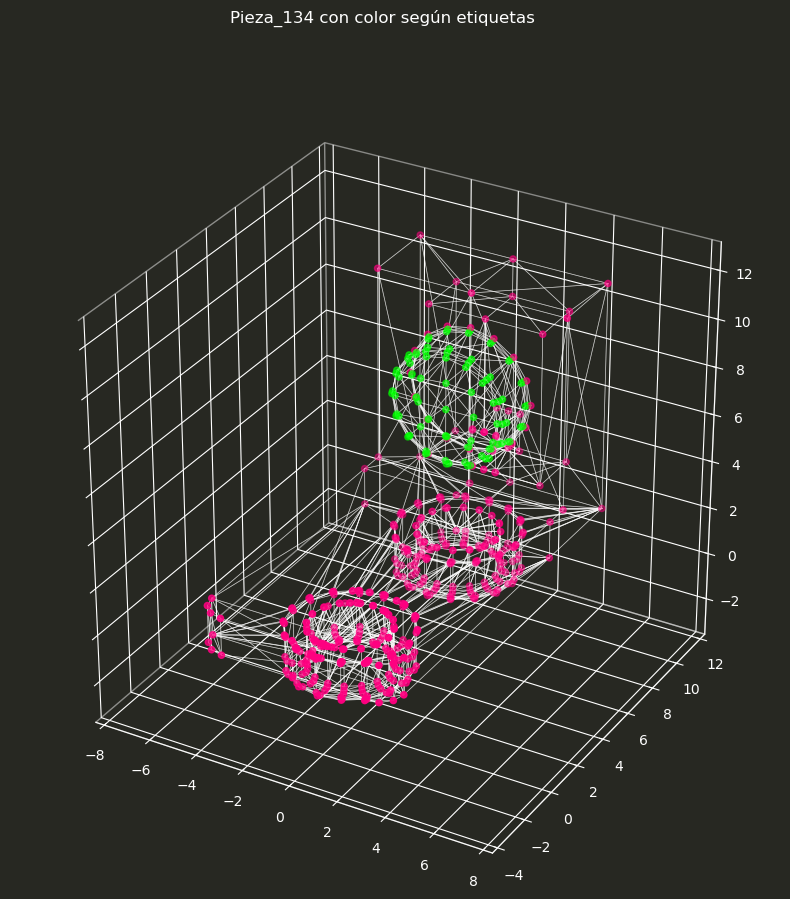

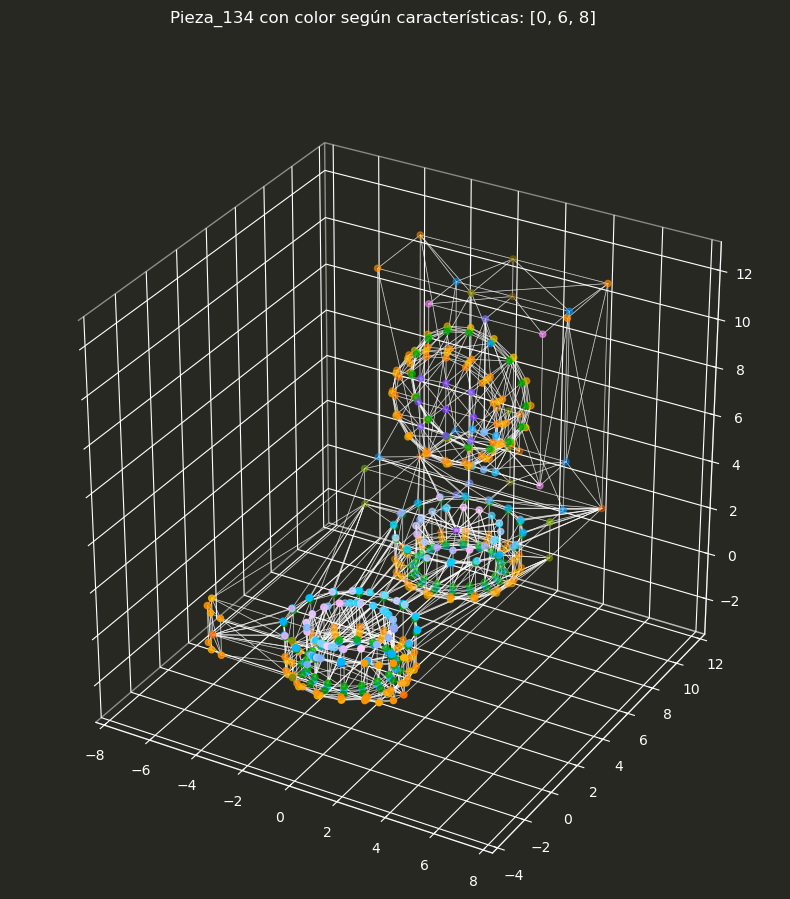

In [ ]:
# Index of the piece to show (recomendado: 12,21,22,134)
sample_piece = 134
fig1, ax1 = plot_piece(dataset[sample_piece])
fig1.suptitle('Pieza_'+str(sample_piece)+' con color según etiquetas')

fts = [0,6,8]
fig2, ax2 = plot_piece(dataset[sample_piece],fts = fts)
fig2.suptitle('Pieza_'+str(sample_piece)+' con color según características: '+str(fts))

Una vez cargados los grafos, se hace un split para crear dos conjuntos de datos, uno para el entrenamiento (training dataset) y otro para la validación (validation dataset), en una proporciona de 80% y 20% respectivamente. El vector de índices se almacena para posteriormente pueda ser usado como referencia para verificar el desempeño del modelo al hacer predicciones.

In [ ]:
import random

training_graphs = 172

idx = np.array(range(0,num_graphs),dtype='int')

# Shuffle the indices
random.shuffle(idx)

# Get index for training graphs
idx_training = idx[:training_graphs]
idx_validation = idx[training_graphs:]

# Indexes used for the example:
# idx_training = [36,5,159,97,42,125,101,84,102,95,60,90,21,142,107,2,129,185,68,184,157,192,33,170,168,93,179,147,18,115,122,194,37,158,94,51,8,67,53,163,34,117,207,62,38,190,187,105,99,176,4,35,133,167,0,145,178,24,80,113,181,20,212,135,32,140,39,89,19,76,59,104,91,213,134,139,138,52,28,156,195,17,66,25,56,112,123,29,83,54,154,110,96,14,98,148,43,175,46,23,55,49,169,79,82,177,188,11,127,64,85,202,6,69,141,174,196,100,164,45,155,75,180,15,86,12,165,40,143,183,189,118,26,61,73,186,146,88,197,109,210,209,108,78,72,87,103,13,203,151,71,77,208,48,57,10,22,144,205,166,111,171,191,106,65,200,92,31,172,126,16,121]
# idx_validation = [160,47,116,58,132,149,114,81,137,198,30,201,120,44,161,130,63,41,182,199,50,211,162,124,7,3,1,131,119,152,193,70,9,27,150,204,136,206,74,128,153,173]

# Divide the dataset into train and test
train_dataset = [dataset[i] for i in idx_training]
validation_dataset = [dataset[i] for i in idx_validation]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(validation_dataset)}')

# In case you want to know the pieces used for training and validation: 

print('Index of graphs for training: ')
for i in idx_training: print(i,end=',')
print('')
print('Index of graphs for validation: ')
for i in idx_validation: print(i,end=',')


Number of training graphs: 172
Number of test graphs: 42
Index of graphs for training: 
66,143,156,179,17,74,142,168,5,99,20,102,153,133,115,176,41,9,0,56,42,183,47,87,129,185,211,152,6,193,120,138,33,101,134,113,44,136,106,89,29,32,146,128,139,161,18,72,150,92,38,3,49,167,14,164,61,75,62,69,104,93,175,12,184,182,45,64,159,210,13,58,125,162,166,174,25,201,57,165,199,114,191,55,196,16,109,76,212,189,10,68,11,190,148,160,209,70,206,197,24,30,117,34,84,170,178,154,63,85,171,195,112,97,8,82,54,202,213,186,205,43,81,60,132,194,140,31,108,187,155,200,50,98,80,53,116,52,40,127,192,188,107,86,208,73,77,173,105,78,177,110,2,172,137,118,37,94,130,135,163,59,95,48,83,23,88,169,181,207,121,26,
Index of graphs for validation: 
126,67,19,22,90,91,4,149,131,144,141,65,100,203,39,36,7,124,46,151,51,147,21,1,71,79,122,28,157,198,158,35,123,119,15,103,204,145,111,180,96,27,

Para conocer el balance del conjunto de datos total se cuentan los vértices que pertenecen a un stud y los que no:

In [ ]:
total_nodes = 0
stud_nodes = 0
for data in dataset:
    total_nodes += data.num_nodes
    stud_nodes += torch.sum(data.y).tolist()

print('Total number of nodes: ', total_nodes)
print('Total number of nodes in studs: ', stud_nodes)
print(stud_nodes/total_nodes *100,'% of nodes are stud nodes')

Total number of nodes:  229286
Total number of nodes in studs:  79929
34.85995656080179 % of nodes are stud nodes


Una vez que se definieron los conjuntos de datos de entrenamiento y de validación, se procede a definir la estructura del modelo. Para ello se define en primer lugar el tipo de capa a usar, que es una capa convolucional de grafos, que hereda de un *torch Module* y realiza la siguiente operación:

$$
H^{l+1} = \sigma(AH^lW + b)
$$

EN donde $W$ y $b$ son los parámetros entrenables y $l$ es el número de la capa. Nótese que los parámetros entrenables son dependientes únicamente del tamaño de entrada $I$ y el tamaño de salida $O$, mientras que la salida de la capa tiene la forma $N\times O$:

$$
(N\times O)_{H^{l+1}} = (N\times N)_A(N\times I)_{H^l}(I\times O)_W + O_b
$$

De manera que, para la primera capa $l = 1$, el tamaño de entrada es igual al número de características que tiene cada nodo (i.e $ I = F = 9 $ ) y el tamaño de salida es un hiperparámetro, por lo que el tamaño de las capas posteriores serán definidas manualmente y torch debe aplicar un broadcast al bias $b$ para poder realizar la suma matricial con el producto matricial previo. Se puede observar que el número de nodos $N$ puede cambiar, por lo que el modelo puede ser generalizado para grafos con distinto número de nodos y distinta estructura.

In [ ]:
import math
from torch import nn
from torch.nn import Linear
import torch.nn.functional as F


class CustomGCN(nn.Module):
    
    """ Custom Graph Convolutional Layer """
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        # Create the W matrix and the bias matrix
        # (define them as nn.Parameter)
        W = torch.Tensor(size_in, size_out)
        self.W = nn.Parameter(W)  

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))            # weight init
        
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)                  # bias init

    def forward(self, x,A):
        H_new = torch.mm(torch.mm(A,x),self.W)    
        return torch.add(H_new, self.bias)  


Con el tipo de capa definido se pueden definir distintos modelos variando tanto el número de capas $l$ como el tamaño de los filtros $W$ , en este caso, el mejor resultado se obtuvo con 4 capas $C_{1...4}$ con filtros $W_{1...4}$ de tamaños $(9,16), (16,32), (32,16)$ y $(16,8)$ respectivamente, con un clasificador lineal al final, resultando en la siguiente operación:

$$
C_1 = tanh( AXW^1 + b^1)\\
C_2 = tanh( AC_1W^2 + b^2)\\
C_3 = tanh( AC_2W^3 + b^3)\\
C_4 = tanh( AC_3W^4 + b^4)\\

Out_i = W^5C_{4i} + b^5

$$

Finalmente, a la salida se aplica un clasificador lineal con dos salidas, correspondientes a las clases Stud $(1)$ y No Stud $(0)$

In [ ]:
class GCN_4L(torch.nn.Module):

    def __init__(self):
        super(GCN_4L, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = CustomGCN(9, 16)
        self.conv2 = CustomGCN(16, 32)
        self.conv3 = CustomGCN(32, 16)
        self.conv4 = CustomGCN(16, 8)
        self.classifier = Linear(8, 2)

    def forward(self, x, A):

        # Convolutional layers
        x = self.conv1(x, A)
        x = x.tanh()
        x = self.conv2(x, A)
        x = x.tanh()
        x = self.conv3(x, A)
        x = x.tanh()
        x = self.conv4(x, A)
        x = x.tanh()
        
        # Apply final classifier
        out = self.classifier(x)
        
        return out

In [ ]:
# Visualize model:
model = GCN_4L()
print(model)

GCN_4L(
  (conv1): CustomGCN()
  (conv2): CustomGCN()
  (conv3): CustomGCN()
  (conv4): CustomGCN()
  (classifier): Linear(in_features=8, out_features=2, bias=True)
)


Se define el método de optimización y la función  de pérdida, en este caso se optó por el método de momento adaptativo y la función de pérdida de entropía cruzada

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

Posteriormente se define la etapa de entrenamiento y la etapa validación, para verificar el desempeño del modelo en cada época se usa la función de balanced accuracy, ya que el dataset cuenta con una relación 35 - 65, y el accuracy clásico estaría sesgado. 

In [ ]:
from sklearn.metrics import balanced_accuracy_score

def train():
    model.train()
    
    # Iterate over the batches in the train dataset
    for data in train_dataset:  
           
        out = model(data.x, data.A )                        # Perform a single forward pass.
        loss = criterion(out, data.y.flatten())             # Compute the loss.
        loss.backward()                                     # Derive gradients.
        optimizer.step()                                    # Update parameters based on gradients.
        optimizer.zero_grad()                               # Clear gradients.

def test(dataset_in):
    model.eval()
    correct = 0
    total = 0

    total_out = []
    total_pred = []
    # Iterate over the batches from the input dataset (Loader)
    for data in dataset_in:  
        out = model(data.x, data.A)                         # Evaluate the model
        pred = torch.argmax(out, axis=1)                    # Use the class with highest probability.
        # correct += torch.sum(torch.where(pred == data.y, 1, 0).float()) # Numer of correct predictions in batch
        # total += len(out)                                   # Total number of predictions in batch
        total_out += data.y.tolist()
        total_pred += pred.tolist()

    # Balanced Accuracy and loss
    return balanced_accuracy_score(total_out,total_pred)  



Finalmente se entrena el modelo y se almacena el que tenga un mejor desempeño, para ello se llama a la función $test$ después de cada época y se calcula el balanced accuracy del conjunto de datos de validación, recordando que ninguno de los datos de éste son usados en la etapa de entrenamiento.

In [ ]:
# Training loop
epochs = 150
best_acc = 0

list_train_acc = []
list_val_acc = []

for epoch in range(1, epochs + 1):
    train()

    train_acc = test(train_dataset)
    val_acc = test(validation_dataset)

    list_train_acc.append(train_acc)
    list_val_acc.append(val_acc)

    if val_acc > best_acc :
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')
        print('This model was better, test accuracy:', val_acc)
        best_acc = val_acc

    print(f'Epoch: {epoch:03d}, ' + 
        f'Train Acc: {train_acc:.4f}, ' + 
        f'Val Acc: {val_acc:.4f}, ')

This model was better, test accuracy: 0.6147047589110157
Epoch: 001, Train Acc: 0.6381, Val Acc: 0.6147, 
This model was better, test accuracy: 0.6400197672885095
Epoch: 002, Train Acc: 0.6625, Val Acc: 0.6400, 
This model was better, test accuracy: 0.6617805696096297
Epoch: 003, Train Acc: 0.6792, Val Acc: 0.6618, 
Epoch: 004, Train Acc: 0.6352, Val Acc: 0.6477, 
Epoch: 005, Train Acc: 0.6436, Val Acc: 0.6489, 
Epoch: 006, Train Acc: 0.6598, Val Acc: 0.6552, 
This model was better, test accuracy: 0.6882489914037022
Epoch: 007, Train Acc: 0.7032, Val Acc: 0.6882, 
Epoch: 008, Train Acc: 0.6741, Val Acc: 0.6587, 
Epoch: 009, Train Acc: 0.6882, Val Acc: 0.6651, 
This model was better, test accuracy: 0.6985650638278103
Epoch: 010, Train Acc: 0.7098, Val Acc: 0.6986, 
Epoch: 011, Train Acc: 0.6793, Val Acc: 0.6605, 
Epoch: 012, Train Acc: 0.7075, Val Acc: 0.6965, 
Epoch: 013, Train Acc: 0.7073, Val Acc: 0.6971, 
This model was better, test accuracy: 0.699737528924084
Epoch: 014, Train Acc:

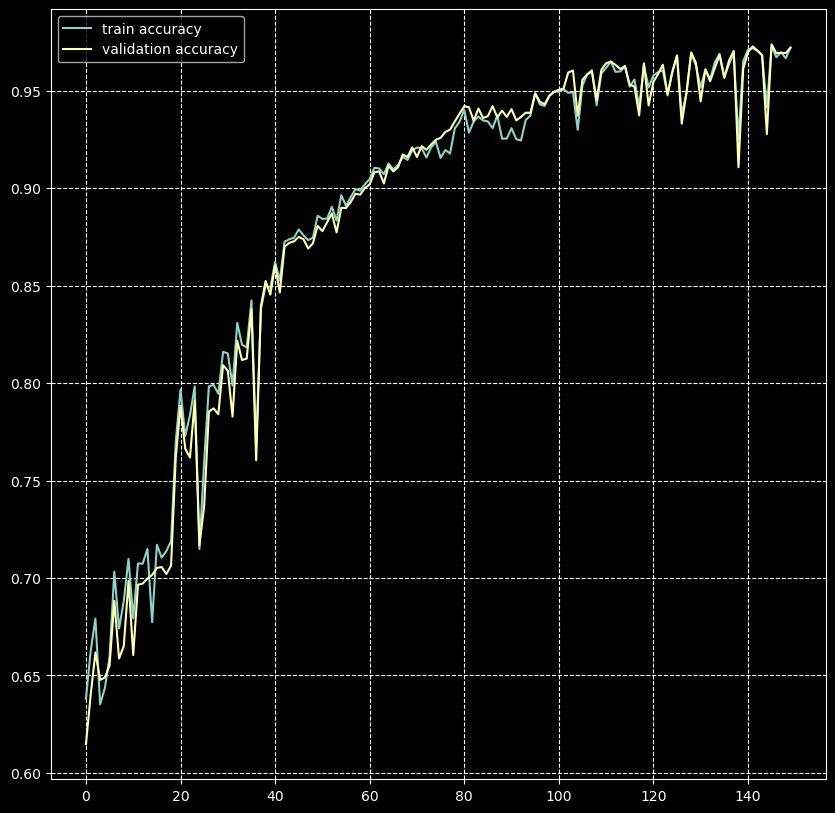

In [ ]:
plt.figure()
plt.grid(color=(1,1,1,0.5),linestyle='--')
plt.plot(list_train_acc)
plt.plot(list_val_acc)
plt.legend(['train accuracy','validation accuracy'])



# Prueba del mejor modelo obtenido

Para verificar visualmente el desempeño del modelo, se recupera el mejor modelo obtenido en el entrenamiento

In [ ]:
# Load the best model
best_model = GCN_4L()
dict_best_model = torch.load('outputs/best_model.pth')
best_model.load_state_dict(dict_best_model['model_state_dict'])
best_model.eval()

GCN_4L(
  (conv1): CustomGCN()
  (conv2): CustomGCN()
  (conv3): CustomGCN()
  (conv4): CustomGCN()
  (classifier): Linear(in_features=8, out_features=2, bias=True)
)

Además de probar con el conjunto de validación se carga un tercer conjunto de pruebas, el cual contiene 22 piezas nuevas que cuentan con características estructurales interesantes para proner a prueba el modelo, cabe recalcar que éste último conjunto de pruebas no cambia con cada ejecución, mientras que el de validación puede variar cada qeu se reinicia este notebook.

In [ ]:
path = 'Bricks_test_9f/'
test_dataset= []

# Iterate over the files
for graph in range(0,22 ):
    
    print(f'Loading graph {graph + 1} / {22} ...')
    name = 'Pieza_' + str(graph)    
    edge_index = torch.tensor((np.genfromtxt(path+name+'_edges.csv', delimiter=',').T), dtype=torch.long)
    x = torch.tensor((np.genfromtxt(path+name+'_features.csv', delimiter=',').T), dtype=torch.float)
    y = torch.tensor((np.genfromtxt(path+name+'_target.csv', delimiter=',').T), dtype=torch.long)
    data = Graph(x=x, edge_index=edge_index,y=y,name=name,path=path)
    test_dataset.append(data) 
    

print(f'Loaded Dataset with {len(test_dataset)} graphs')

Loading graph 1 / 22 ...
Loading graph 2 / 22 ...
Loading graph 3 / 22 ...
Loading graph 4 / 22 ...
Loading graph 5 / 22 ...
Loading graph 6 / 22 ...
Loading graph 7 / 22 ...
Loading graph 8 / 22 ...
Loading graph 9 / 22 ...
Loading graph 10 / 22 ...
Loading graph 11 / 22 ...
Loading graph 12 / 22 ...
Loading graph 13 / 22 ...
Loading graph 14 / 22 ...
Loading graph 15 / 22 ...
Loading graph 16 / 22 ...
Loading graph 17 / 22 ...
Loading graph 18 / 22 ...
Loading graph 19 / 22 ...
Loading graph 20 / 22 ...
Loading graph 21 / 22 ...
Loading graph 22 / 22 ...
Loaded Dataset with 22 graphs


In [ ]:
def test_best_model(dataset_in):
    best_model.eval()
    correct = 0
    total = 0

    total_out = []
    total_pred = []
    # Iterate over the batches from the input dataset (Loader)
    for data in dataset_in:  
        out = best_model(data.x, data.A)                    # Evaluate the model
        pred = torch.argmax(out, axis=1)                    # Use the class with highest probability.
        total_out += data.y.tolist()
        total_pred += pred.tolist()

    return balanced_accuracy_score(total_out,total_pred)

val_acc = test_best_model(validation_dataset)
test_acc = test_best_model(test_dataset)

print(f'The balanced accuracy of the model using the validation dataset is: {val_acc:.4f}')
print(f'The balanced accuracy of the model using the test dataset is: {test_acc:.4f}')

The balanced accuracy of the model using the validation dataset is: 0.9738
The balanced accuracy of the model using the test dataset is: 0.9573


Para visualizar algunos ejemplos del conjunto de validación:

Text(0.5, 0.98, 'Pieza 2 del conjunto de validación')

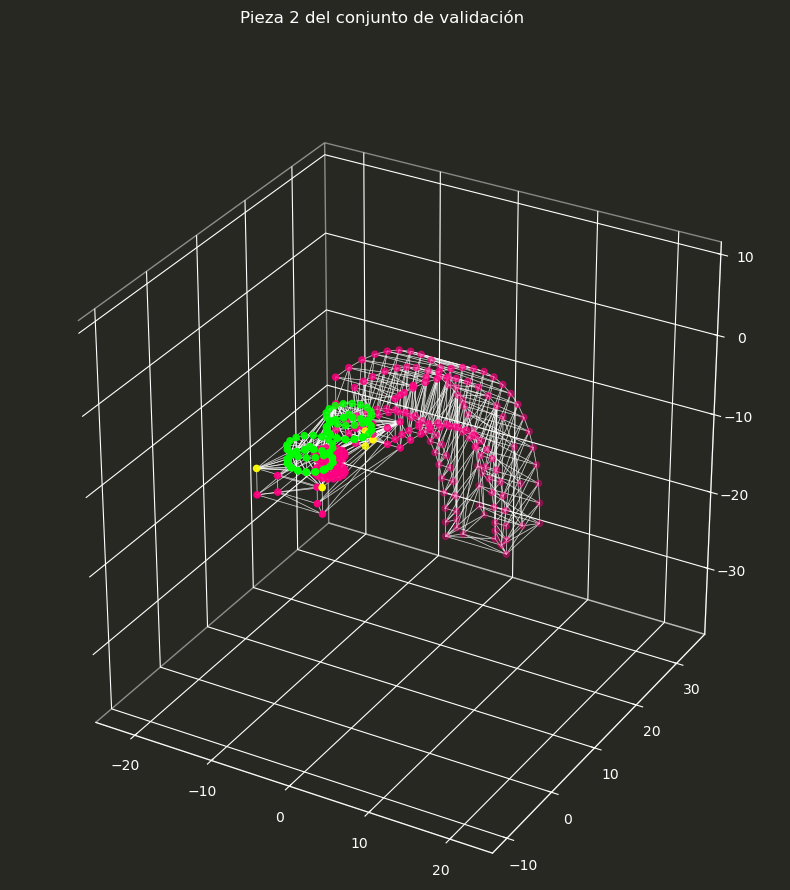

In [ ]:
index_validation = 2
val_graph = validation_dataset[index_validation]

best_model.eval()
out = best_model(val_graph.x,val_graph.A)
pred = torch.argmax(out, axis=1).tolist()
fig3,ax3 = plot_piece(val_graph,pred=pred)
fig3.suptitle('Pieza '+str(index_validation)+' del conjunto de validación')

Para visualizar algunos ejemplos del conjunto de prueba:

Text(0.5, 0.98, 'Pieza 3 del conjunto de validación')

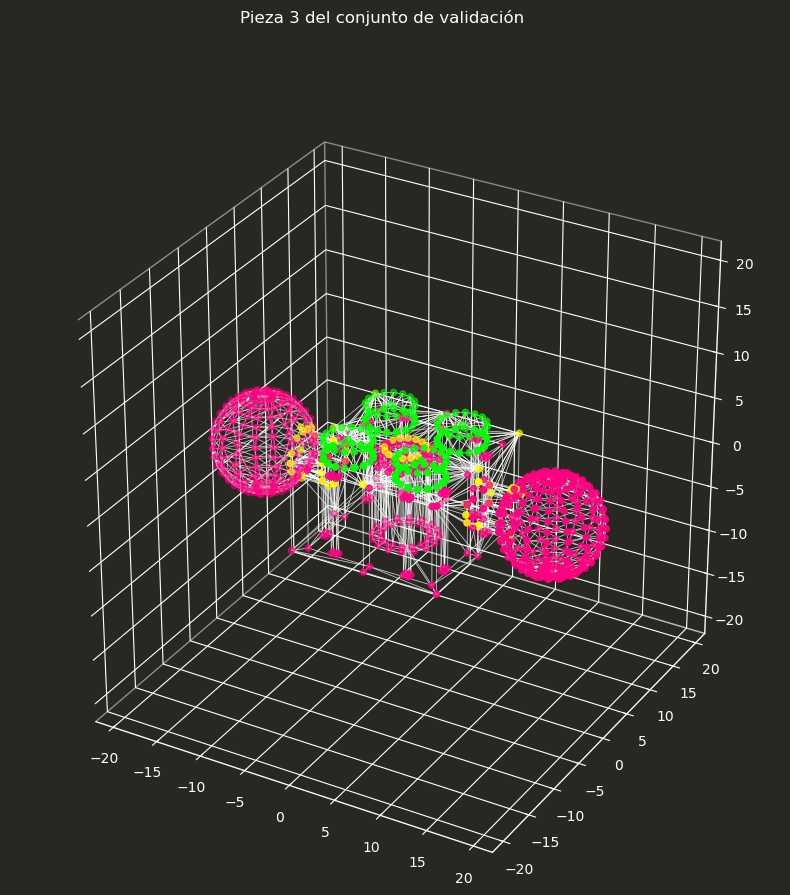

In [ ]:
# from 0 to 22
index_test = 3
test_graph = test_dataset[index_test]

best_model.eval()
out = best_model(test_graph.x,test_graph.A)
pred = torch.argmax(out, axis=1).tolist()
fig4,ax4 = plot_piece(test_graph,pred=pred)
fig4.suptitle('Pieza '+str(index_test)+' del conjunto de validación')

Repitiendo el proceso a partir del split del conjunto de datos se obtienen modelos diferentes que llegan a un accuracy superior a 90%, sin embargo, esto no garantiza un mejor desempeño del modelo en el conjunto de prueba. En la siguientes imágenes se comparan tres modelos con accuracy de 95%, 96% y 98% respectivamente:

<p style="text-align:center;">
<img src="src/eval/Pieza_0_a.png" width="1800"  />
<img src="src/eval/Pieza_0_b.png" width="1800"  />
<img src="src/eval/Pieza_1_a.png" width="1800"  />
<img src="src/eval/Pieza_1_b.png" width="1800"  />
<img src="src/eval/Pieza_2_a.png" width="1800"  />
<img src="src/eval/Pieza_2_b.png" width="1800"  />
<img src="src/eval/Pieza_3_a.png" width="1800"  />
<img src="src/eval/Pieza_3_b.png" width="1800"  />
<img src="src/eval/Pieza_4_a.png" width="1800"  />
<img src="src/eval/Pieza_4_b.png" width="1800"  />
<img src="src/eval/Pieza_5_a.png" width="1800"  />
<img src="src/eval/Pieza_5_b.png" width="1800"  />
<img src="src/eval/Pieza_5_c.png" width="1800"  />
<img src="src/eval/Pieza_6_a.png" width="1800"  />
<img src="src/eval/Pieza_6_b.png" width="1800"  />
<img src="src/eval/Pieza_7_a.png" width="1800"  />
<img src="src/eval/Pieza_7_b.png" width="1800"  />
<img src="src/eval/Pieza_8_a.png" width="1800"  />
<img src="src/eval/Pieza_8_b.png" width="1800"  />
<img src="src/eval/Pieza_9_a.png" width="1800"  />
<img src="src/eval/Pieza_9_b.png" width="1800"  />
<img src="src/eval/Pieza_10_a.png" width="1800"  />
<img src="src/eval/Pieza_10_b.png" width="1800"  />
<img src="src/eval/Pieza_11_a.png" width="1800"  />
<img src="src/eval/Pieza_11_b.png" width="1800"  />
<img src="src/eval/Pieza_12_a.png" width="1800"  />
<img src="src/eval/Pieza_12_b.png" width="1800"  />
<img src="src/eval/Pieza_13_a.png" width="1800"  />
<img src="src/eval/Pieza_13_b.png" width="1800"  />
<img src="src/eval/Pieza_14_a.png" width="1800"  />
<img src="src/eval/Pieza_14_b.png" width="1800"  />
<img src="src/eval/Pieza_15_a.png" width="1800"  />
<img src="src/eval/Pieza_15_b.png" width="1800"  />
<img src="src/eval/Pieza_16_a.png" width="1800"  />
<img src="src/eval/Pieza_16_b.png" width="1800"  />
<img src="src/eval/Pieza_17_a.png" width="1800"  />
<img src="src/eval/Pieza_17_b.png" width="1800"  />
<img src="src/eval/Pieza_18_a.png" width="1800"  />
<img src="src/eval/Pieza_18_b.png" width="1800"  />
<img src="src/eval/Pieza_19_a.png" width="1800"  />
<img src="src/eval/Pieza_19_b.png" width="1800"  />
<img src="src/eval/Pieza_20_a.png" width="1800"  />
<img src="src/eval/Pieza_20_b.png" width="1800"  />


<figcaption align='center'> Figura 2.4 - Piezas del conjunto de prueba evaluada en modelos con 95, 96 y 98% de accuracy respectivamente </figcaption>


